In [2]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path
from scipy.stats import multivariate_normal
import ipywidgets as widgets
from IPython.display import display
import pandas as pd


In [36]:
def loadFile(filename):
    '''
    Reads in data file
    '''
    
    if 'Barcodes' in filename:
        col_name = ['Subject', 'Barcode']
    elif 'Landmark_Groundtruth' in filename:
        col_name = ['Subject', 'x', 'y', 'x_std', 'y_std']
    elif 'Groundtruth' in filename:
        col_name = ['Time', 'x', 'y', 'orientation']
    elif 'Measurement' in filename:
        col_name = ['Time', 'Subject', 'Range', 'Bearing']
    else:
        col_name = ['Time', 'Forward Velocity', 'Angular Velocity']
        
    data = pd.read_csv(filename, names = col_name, comment="#", delimiter = "\t", skipinitialspace = True)
    
    return data

In [38]:
loadFile("./MRCLAM_Dataset1/Landmark_Groundtruth.dat")

,Subject,x,y,x_std,y_std
0,6,5.709283,4.964045,0.000275,0.000415
1,7,5.252926,5.536569,0.000119,0.000354
2,8,3.699877,4.466423,0.000115,0.000212
3,9,2.314463,3.374987,0.000118,0.000121
4,10,0.481799,4.395972,0.000107,0.000185
5,11,3.150720,2.382949,0.000126,0.000138
6,12,4.063288,0.944294,0.000061,0.000134
7,13,2.680344,0.268352,0.000099,0.000095
8,14,0.948285,0.756013,0.000169,0.000151
9,15,3.762902,-2.030915,0.000115,0.000175


In [ ]:
'''
How to deal with non time sync odometry and measurements
- email to clark?
- could potentially assume it's insignificant

Big consideration
- Won't get a full measurement vector every time we correct!
- correct this line instead of correct the whole thing

### Answers to design questions

What do we want in our state vector:
- x, y, yaw
- use all 5 robots initially, see if run time blows up

For measurements
- x and y of all five robots (doesn't seem to be a way to correct yaw)
- ask about predicting yaw

Time stamps across five robots might not be synced!

'''

In [69]:
robot1_gt = loadFile("./MRCLAM_Dataset1/Robot1_Groundtruth.dat")
robot2_gt = loadFile("./MRCLAM_Dataset1/Robot2_Groundtruth.dat")
robot3_gt = loadFile("./MRCLAM_Dataset1/Robot3_Groundtruth.dat")
robot4_gt = loadFile("./MRCLAM_Dataset1/Robot4_Groundtruth.dat")
robot5_gt = loadFile("./MRCLAM_Dataset1/Robot5_Groundtruth.dat")

robot1_odo = loadFile("./MRCLAM_Dataset1/Robot1_Odometry.dat")
robot2_odo = loadFile("./MRCLAM_Dataset1/Robot2_Odometry.dat")

In [47]:
robot1_gt_x = robot1_gt['x'].to_numpy()
robot2_gt_x = robot2_gt['x'].to_numpy()
robot3_gt_x = robot3_gt['x'].to_numpy()
robot4_gt_x = robot4_gt['x'].to_numpy()
robot5_gt_x = robot5_gt['x'].to_numpy()

robot1_gt_y = robot1_gt['y'].to_numpy()
robot2_gt_y = robot2_gt['y'].to_numpy()
robot3_gt_y = robot3_gt['y'].to_numpy()
robot4_gt_y = robot4_gt['y'].to_numpy()
robot5_gt_y = robot5_gt['y'].to_numpy()

robot1_gt_time = robot1_gt['Time'].to_numpy()


In [70]:
robot1_odo_time = robot1_odo['Time'].to_numpy()
robot2_odo_time = robot2_odo['Time'].to_numpy()

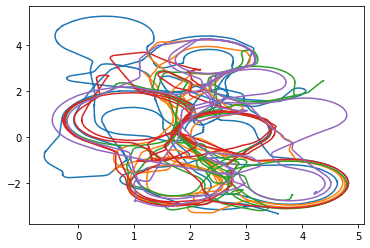

In [44]:
plt.plot(robot1_gt_x, robot1_gt_y)
plt.plot(robot2_gt_x, robot2_gt_y)
plt.plot(robot3_gt_x, robot3_gt_y)
plt.plot(robot4_gt_x, robot4_gt_y)
plt.plot(robot5_gt_x, robot5_gt_y)

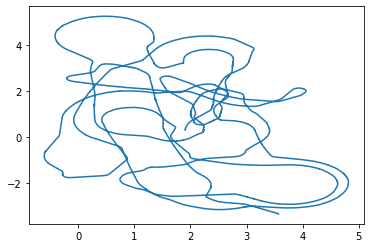

In [45]:
plt.plot(robot1_gt_x, robot1_gt_y)


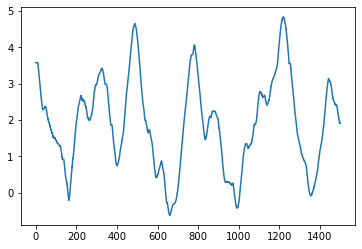

In [52]:
plt.plot(robot1_gt_time - robot1_gt_time[0], robot1_gt_x)


In [61]:
ts = robot1_gt_time[100] - robot1_gt_time[99] 
dx = robot1_gt_x[100] - robot1_gt_x[99]

In [63]:
dx/ts

-0.0007000016493032707

In [64]:
dx, ts

(-2.3800000000129273e-05, 0.03399991989135742)

In [67]:
robot1_gt_x

array([3.5732324, 3.5732247, 3.573238 , ..., 1.9074724, 1.9067457,
       1.9062726])

In [66]:
robot1_odo

,Time,Forward Velocity,Angular Velocity
0,1.248272e+09,0.074,0.229
1,1.248272e+09,0.074,0.229
2,1.248272e+09,0.074,0.229
3,1.248272e+09,0.074,0.229
4,1.248272e+09,0.074,0.229
5,1.248272e+09,0.074,0.230
6,1.248272e+09,0.074,0.230
7,1.248272e+09,0.074,0.229
8,1.248272e+09,0.074,0.229
9,1.248272e+09,0.074,0.229
